<a href="https://colab.research.google.com/github/Santoshuske/Text-Classification-/blob/main/AG_News_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import data from kaggle

In [1]:
#!unzip road_signs.zip
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [2]:
dataset_url = 'https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: santoshuske
Your Kaggle Key: ··········


100%|██████████| 11.4M/11.4M [00:01<00:00, 7.71MB/s]


# install transformers

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 22.5 MB/s eta 0:00:00


# install datasets

In [4]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 16.1 MB/s eta 0:00:00


# import library

In [5]:
# For general data processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt

# To import the Transformer Models
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, logging

# to convert to dataset datatype - the transformers library does not work well with pandas
from datasets import Dataset

# combine two columns title and description

In [6]:
#import data and combine title and description column 
def import_data(csv_file):
    """
    Import the csv file and get it ready for use. Ensures each file gets the same treatment.
    
    in -> csv_file - string representing the location of the csv file
    out -> pandas dataframe
    """
    df = pd.read_csv(csv_file)
    df['text'] = df['Title'] + ' ' + df['Description']
    df.rename(columns = {'Class Index': 'label'}, inplace = True)
    # The models expects numerical catagories  starting from 0 Not 1
    df['label'].replace({4:0}, inplace = True)
    df.drop(['Title', 'Description'], axis = 1, inplace = True)
    
    return df

# Read train Data

In [7]:
train = import_data('/content/ag-news-classification-dataset/train.csv')

In [8]:
train.shape

(120000, 2)

In [9]:
train.head()

,label,text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


In [24]:
train['label'].unique()

array([3, 0, 2, 1])

Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: label, dtype: int64


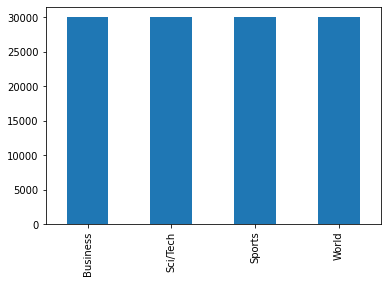

In [26]:
# Visualising the distribution of the target variable.

sentiment = {0:"Sci/Tech", 1:"World",2:"Sports",3:"Business"}
print(train.label.apply(lambda x: sentiment[x]).value_counts())
train.label.apply(lambda x: sentiment[x]).value_counts().plot(kind = 'bar')
plt.show()

# WordCloud

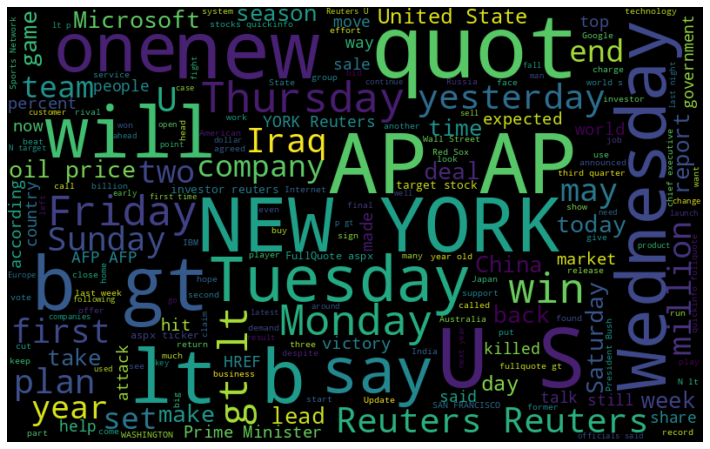

In [27]:
# visualize the frequent words
from wordcloud import WordCloud
all_words = " ".join([sentence for sentence in train['text']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# 1 represents World, 2 represents Sports, 3 represents Business and 4 represents Sci/Tech

# WordCloud Sci/Tech

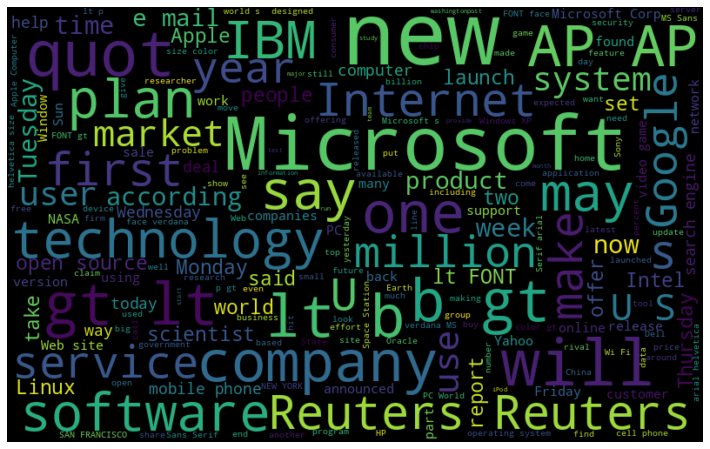

In [28]:
# frequent words visualization for +ve
#Sci/Tech
all_words = " ".join([sentence for sentence in train['text'][train['label']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# WordCloud World

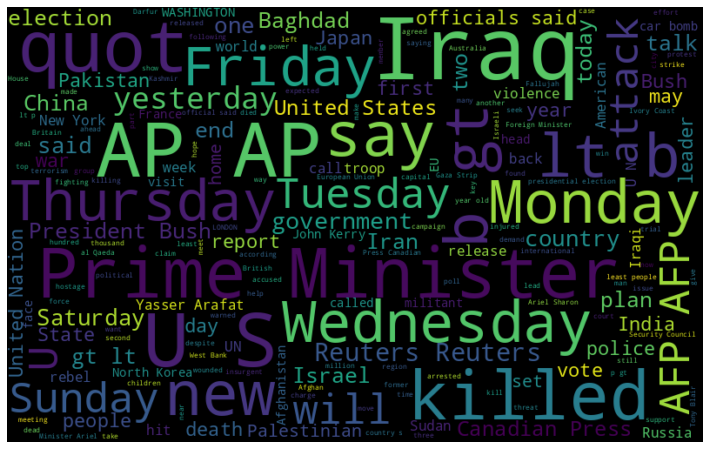

In [29]:
# frequent words visualization for +ve
#World
all_words = " ".join([sentence for sentence in train['text'][train['label']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# WordCloud Sports

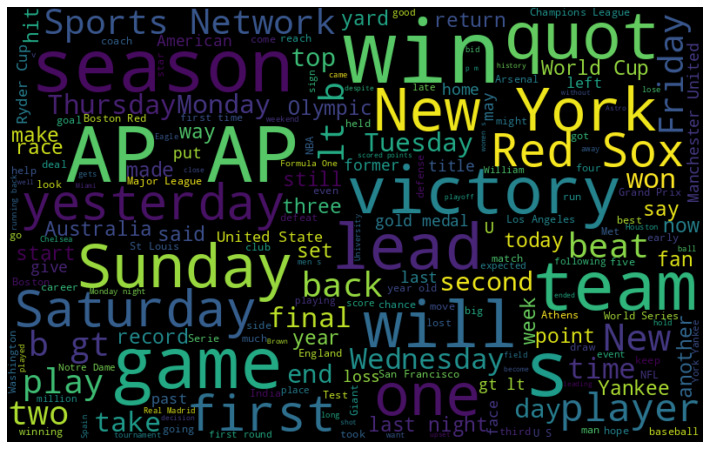

In [30]:
# frequent words visualization for +ve
#Sports
all_words = " ".join([sentence for sentence in train['text'][train['label']==2]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# WordCloud Business

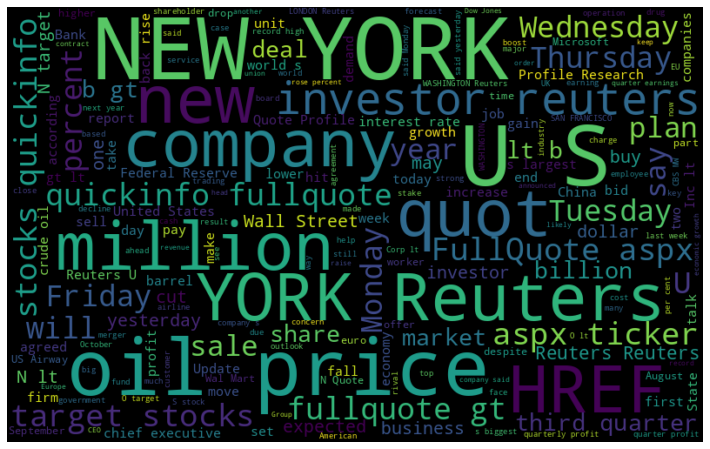

In [31]:
# frequent words visualization for +ve
#Business
all_words = " ".join([sentence for sentence in train['text'][train['label']==3]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Read Test Data

In [10]:
test= import_data('/content/ag-news-classification-dataset/test.csv')

# Model

In [12]:
pretrained_model = "bert-base-uncased"

# Use 50000 rows

In [13]:
#only using 50000 rows out of 120000
train_val=train.iloc[:50000,]

In [18]:
train_val.shape

(50000, 2)

# split train dataframe into train and val

In [19]:
train_df, val_df = train_test_split(train_val[['text', 'label']], 
                                    test_size = 0.2, random_state = 42)

In [20]:
print(train_df.shape)
print(val_df.shape)

(40000, 2)
(10000, 2)


# Tokenizer

In [15]:
# Tokenize the text
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

def preprocess_function(examples):
    """
    Tokenize the text to create input and attention data
    
    in -> dataset (columns = text, label)
    out -> tokenized dataset (columns = text, label, input, attention)
    """
    return tokenizer(examples["text"], truncation=True)


def pipeline(dataframe):
    """
    Prepares the dataframe so that it can be given to the transformer model
    
    in -> pandas dataframe
    out -> tokenized dataset (columns = text, label, input, attention)
    """    
    # This step isn't mentioned anywhere but is vital as Transformers library only seems to work with this Dataset data type
    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    tokenized_ds = dataset.map(preprocess_function, batched=True)
    tokenized_ds = tokenized_ds.remove_columns('text')
    return tokenized_ds

In [21]:
tokenized_train = pipeline(train_df)
tokenized_val = pipeline(val_df)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

# Train

In [23]:
# Set values for model and train
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=4)

training_args = TrainingArguments(
    output_dir="./results",
    # important as the standard setting of 500 creates too much data
    save_strategy = 'epoch',
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    report_to="none", # Stops transformers from trying to connect to weights and biases site
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

%time trainer.train()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
 

Step,Training Loss
500,0.393700
1000,0.252000
1500,0.237100
2000,0.223300
2500,0.210000
3000,0.157900
3500,0.145600
4000,0.148900
4500,0.153600
5000,0.147200


Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-2500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-2500/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-5000
Configuration saved in ./results/checkpoint-5000/config.json
Model weights saved in ./results/checkpoint-5000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-5000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-5000/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-7500
Configuration saved in ./results/checkpoint-7500/config.json
Model weights saved in ./results/checkpoint-7500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-7500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-7500/special

CPU times: user 56min 37s, sys: 4min 24s, total: 1h 1min 2s
Wall time: 1h 2min 56s


TrainOutput(global_step=12500, training_loss=0.1186251693725586, metrics={'train_runtime': 3776.7033, 'train_samples_per_second': 52.956, 'train_steps_per_second': 3.31, 'total_flos': 1.0024201434833664e+16, 'train_loss': 0.1186251693725586, 'epoch': 5.0})

# Test

In [32]:
tokenized_test = pipeline(test)

tokenized_test = tokenized_test.remove_columns('label')

preds = trainer.predict(tokenized_test)

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

***** Running Prediction *****
  Num examples = 7600
  Batch size = 64


# Prediction

In [33]:
preds_flat = [np.argmax(x) for x in preds[0]]

len(preds_flat)

7600

# Confusion Matrix

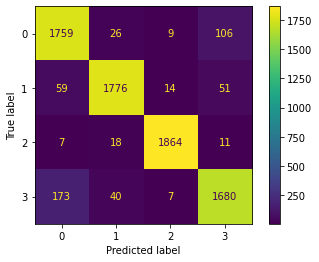

In [34]:
cm = confusion_matrix(test['label'], preds_flat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

plt.show()

# Score

In [35]:
precision, recall, f1score, support = score(test['label'], preds_flat)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('f1score: {}'.format(f1score))
print('support: {}'.format(support))

precision: [0.88038038 0.95483871 0.98416051 0.90909091]
recall: [0.92578947 0.93473684 0.98105263 0.88421053]
f1score: [0.90251411 0.94468085 0.98260411 0.89647812]
support: [1900 1900 1900 1900]


In [39]:
dictt={'Precision':precision,'Recall':recall,'F1score':f1score,'Support':support}

In [51]:
Score=pd.DataFrame(dictt)

In [53]:
Score

,Precision,Recall,F1score,Support
0,0.880380,0.925789,0.902514,1900
1,0.954839,0.934737,0.944681,1900
2,0.984161,0.981053,0.982604,1900
3,0.909091,0.884211,0.896478,1900


In [42]:
import shutil

In [43]:
shutil.make_archive('/content/results','zip','/content/results')

'/content/results.zip'

# Save Model

In [46]:
# Save the fine-tuned model
model.save_pretrained('my_classification_model')

Configuration saved in my_classification_model/config.json
Model weights saved in my_classification_model/pytorch_model.bin


In [47]:
# Load the saved model for inference
from transformers import pipeline

text_classification = pipeline(
    'text-classification',
    model='my_classification_model',
    tokenizer=tokenizer
)

loading configuration file my_classification_model/config.json
Model config BertConfig {
  "_name_or_path": "my_classification_model",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_siz

# Testing on diffrent text

In [48]:
#world Label 1
text = "New York Yankees win the World Series."
predicted_class = text_classification(text)
print(predicted_class)

[{'label': 'LABEL_1', 'score': 0.9975639581680298}]


In [60]:
#Business label 3
text = "Oil prices surge as tensions rise in the Middle East"
predicted_class = text_classification(text)
print(predicted_class)

[{'label': 'LABEL_3', 'score': 0.9966388940811157}]


In [57]:
#sci/tech label 0
text = "Apple unveils new iPhone"
predicted_class = text_classification(text)
print(predicted_class)

[{'label': 'LABEL_0', 'score': 0.9988376498222351}]


In [59]:
#Sports label 2
text = "virat kohli scored 100 in test match"
predicted_class = text_classification(text)
print(predicted_class)

[{'label': 'LABEL_2', 'score': 0.6999866962432861}]


# Conclusion

The news classification is an important task in natural language processing that enables us to categorize news articles into different topics or classes based on their content.

Transformers, specifically the BERT model, have been shown to be highly effective for news classification, outperforming traditional machine learning methods. 

Fine-tuning the pre-trained BERT model on a labeled dataset of news articles allows us to leverage the model's deep understanding of language and context to accurately classify news articles into their respective categories.

 Overall, the use of transformers in news classification is a promising approach that has the potential to significantly improve the accuracy and efficiency of news classification tasks.